In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [13]:
# Load data
df1=pd.read_csv('/Users/ankhanhnguyen/Downloads/round-1-island-data-bottle/prices_round_1_day_-1.csv',delimiter=";")
df2=pd.read_csv('/Users/ankhanhnguyen/Downloads/round-1-island-data-bottle/prices_round_1_day_-2.csv',delimiter=";")
df0=pd.read_csv('/Users/ankhanhnguyen/Downloads/round-1-island-data-bottle/prices_round_1_day_0.csv',delimiter=";")
df1['timestamp']+=999900
df2['timestamp']+=2*999900
df=pd.concat([df0, df1, df2], ignore_index=True)

df

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,RAINFOREST_RESIN,9998,1,9995.0,30.0,NaN,NaN,10005,30,NaN,NaN,NaN,NaN,10001.5,0.0
1,0,0,KELP,2028,30,NaN,NaN,NaN,NaN,2032,30,NaN,NaN,NaN,NaN,2030.0,0.0
2,0,0,SQUID_INK,1968,30,NaN,NaN,NaN,NaN,1971,30,NaN,NaN,NaN,NaN,1969.5,0.0
3,0,100,SQUID_INK,1969,4,1967.0,31.0,NaN,NaN,1971,31,NaN,NaN,NaN,NaN,1970.0,0.0
4,0,100,KELP,2030,4,2028.0,31.0,NaN,NaN,2032,31,NaN,NaN,NaN,NaN,2031.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,-2,2999600,RAINFOREST_RESIN,9996,1,9995.0,25.0,NaN,NaN,9998,1,10002.0,9.0,10004.0,1.0,9997.0,0.0
89996,-2,2999600,KELP,2026,26,NaN,NaN,NaN,NaN,2028,3,2030.0,26.0,NaN,NaN,2027.0,0.0
89997,-2,2999700,RAINFOREST_RESIN,9996,2,9995.0,30.0,NaN,NaN,10004,2,10005.0,30.0,NaN,NaN,10000.0,0.0
89998,-2,2999700,KELP,2027,4,2026.0,32.0,NaN,NaN,2029,32,NaN,NaN,NaN,NaN,2028.0,0.0


## Finding Mean Reversion in SQUID_INK ##
1. Find deviations from ema of fast (20 timesteps) and slow(100 timesteps).
2. Use ADF to confirm mean reversion: if p_value is 0 => the price series is mean reverting
3. Find autocorrelation: basically correlation between consecutive deviations. If value is close to 1, then if today's price is above the EMA, tomorrow's price is likely to stay above it => This suggests short-term momentum before mean reversion occurs.
4. Calculate deviation ratio: the amount of time spent above / the amount of time spent below EMA.
5. Half-life: the amount of time it takes for deviations from EMA to reduce by half.

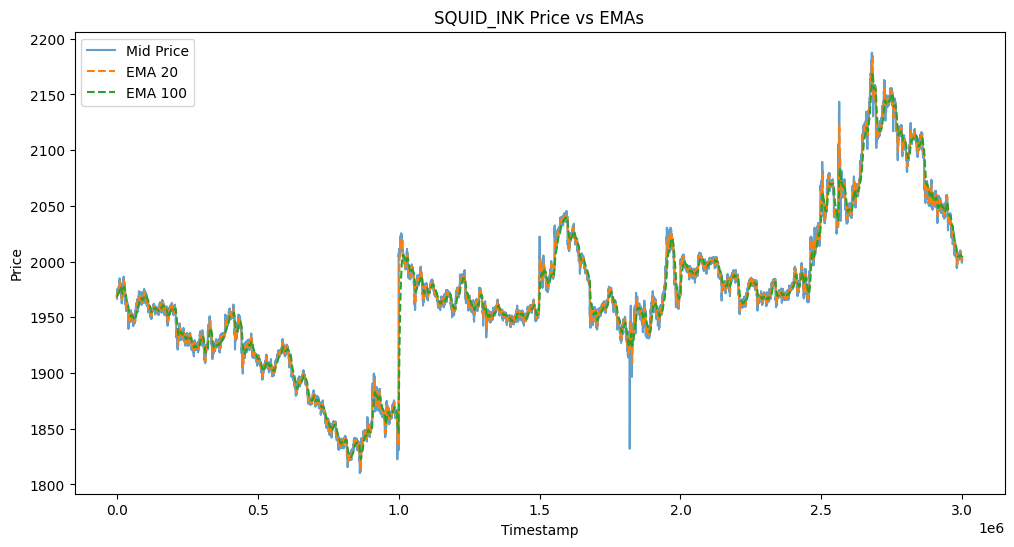

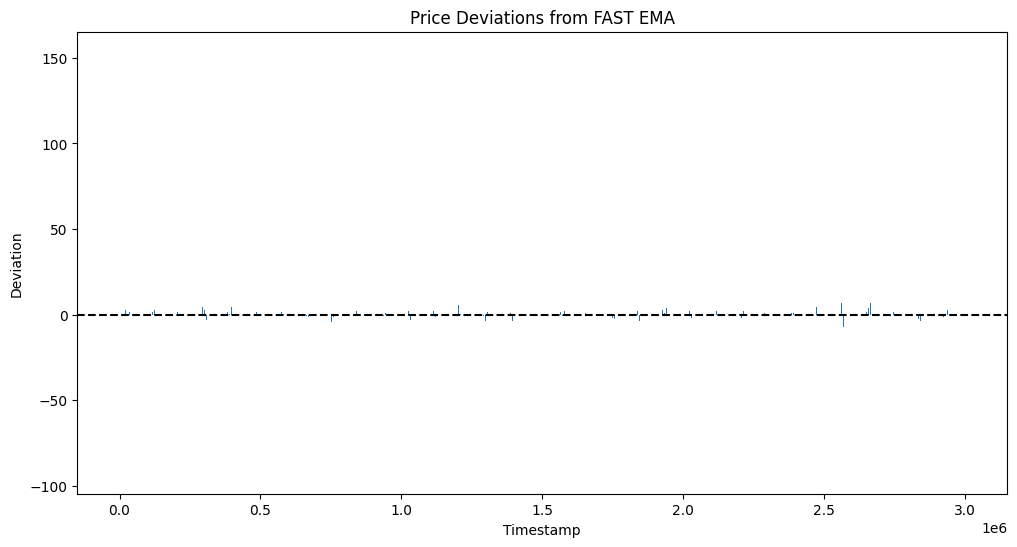

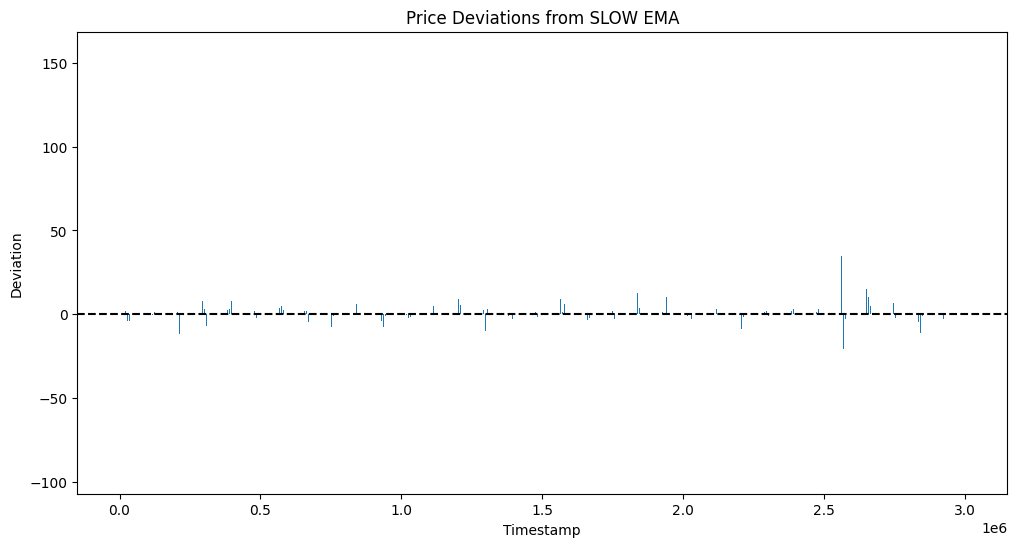


Fast EMA Deviation Analysis:
ADF p-value: 0.0000
Lag-1 Autocorrelation: 0.8756
Positive/Negative Deviation Ratio: 51.11%/48.89%
ADF p-value: 0.0000
Lag-1 Autocorrelation: 0.9714
Positive/Negative Deviation Ratio: 49.80%/50.19%
Mean Reversion Half-Life (Fast EMA): 5.57 periods
Mean Reversion Half-Life (Slow EMA): 24.23 periods


In [18]:
# Squid ink
squid_df = df[df['product'] == 'SQUID_INK'].copy().sort_values('timestamp')

# Can be tweaked gang
span_fast = 20
span_slow = 100

squid_df['ema_fast'] = squid_df['mid_price'].ewm(span=span_fast, adjust=False).mean()
squid_df['ema_slow'] = squid_df['mid_price'].ewm(span=span_slow, adjust=False).mean()

# Deviations from EMA
squid_df['deviation_fast'] = squid_df['mid_price'] - squid_df['ema_fast']
squid_df['deviation_slow'] = squid_df['mid_price'] - squid_df['ema_slow']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(squid_df['timestamp'], squid_df['mid_price'], label='Mid Price', alpha=0.7)
plt.plot(squid_df['timestamp'], squid_df['ema_fast'], label=f'EMA {span_fast}', linestyle='--')
plt.plot(squid_df['timestamp'], squid_df['ema_slow'], label=f'EMA {span_slow}', linestyle='--')
plt.title('SQUID_INK Price vs EMAs')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.show()

# Deviations from fast EMA
plt.figure(figsize=(12, 6))
plt.bar(squid_df['timestamp'], squid_df['deviation_fast'], width=10, label='Fast EMA Deviation')
plt.axhline(0, color='black', linestyle='--')
plt.title('Price Deviations from FAST EMA')
plt.xlabel('Timestamp')
plt.ylabel('Deviation')
plt.show()

# Deviations from slow EMA
plt.figure(figsize=(12, 6))
plt.bar(squid_df['timestamp'], squid_df['deviation_slow'], width=10, label='Fast EMA Deviation')
plt.axhline(0, color='black', linestyle='--')
plt.title('Price Deviations from SLOW EMA')
plt.xlabel('Timestamp')
plt.ylabel('Deviation')
plt.show()


# Test for mean reversion and momentum
def mean_reversion_stats(series):    
    # ADF Test
    result = adfuller(series)
    print(f"ADF p-value: {result[1]:.4f}")
    
    # Autocorrelaton
    lag = 1
    autocorr = series.autocorr(lag)
    print(f"Lag-{lag} Autocorrelation: {autocorr:.4f}")
    
    # Mean reversion ratio
    positive_dev = (series > 0).sum()
    negative_dev = (series < 0).sum()
    print(f"Positive/Negative Deviation Ratio: {positive_dev/len(series):.2%}/{negative_dev/len(series):.2%}")

print("\nFast EMA Deviation Analysis:")
mean_reversion_stats(squid_df['deviation_fast'])
mean_reversion_stats(squid_df['deviation_slow'])

# How long deviations last
def calculate_half_life(series):
    shifted = series.shift(1)
    delta = series - shifted
    beta = np.polyfit(shifted[1:], delta[1:], 1)[0]
    half_life = -np.log(2)/beta
    return half_life

hl_fast = calculate_half_life(squid_df['deviation_fast'])
hl_slow = calculate_half_life(squid_df['deviation_slow'])
print(f"Mean Reversion Half-Life (Fast EMA): {hl_fast:.2f} periods")
print(f"Mean Reversion Half-Life (Slow EMA): {hl_slow:.2f} periods")